# Logistic Regression using PyTorch distributions

### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd

dist =torch.distributions

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Generative model for logistic regression

In [47]:
x = dist.Normal(loc = torch.tensor([0., 0.]), scale=torch.tensor([1., 2.]))
x_sample = x.sample([100])
x_sample.shape

x_dash = torch.concat((torch.ones(x_sample.shape[0], 1), x_sample), axis=1)

In [48]:
theta = dist.MultivariateNormal(loc = torch.tensor([0., 0., 0.]), covariance_matrix=0.5*torch.eye(3))
theta_sample = theta.sample()

p = torch.sigmoid(x_dash@theta_sample)

y = dist.Bernoulli(probs=p)
y_sample = y.sample()

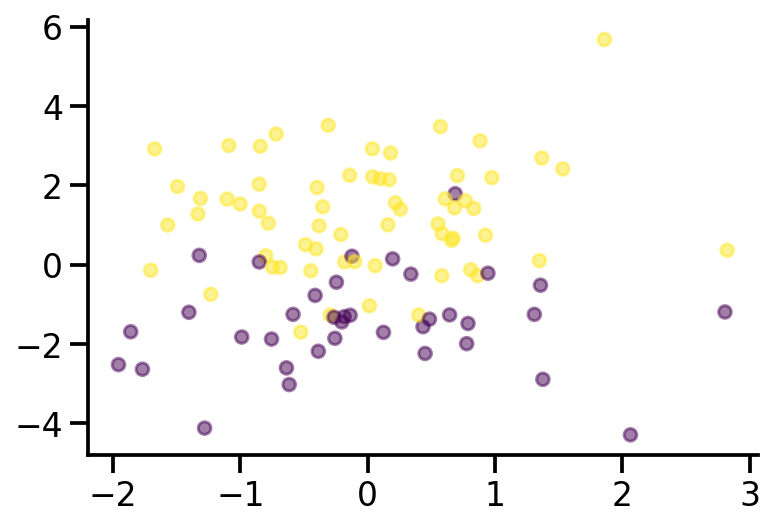

In [53]:
plt.scatter(x_sample[:, 0], x_sample[:, 1], c = y_sample, s=40, alpha=0.5)
sns.despine()

In [90]:
theta_sample

tensor([ 0.6368, -0.7526,  1.4652])

In [79]:
from sklearn.linear_model import LogisticRegression
lr_l2 = LogisticRegression()
lr_none = LogisticRegression(penalty='none')

In [80]:
lr_l2.fit(x_sample, y_sample)
lr_none.fit(x_sample, y_sample)

LogisticRegression(penalty='none')

In [87]:
def plot_fit(x_sample, y_sample, theta, model_name):

    
    # Retrieve the model parameters.
    b = theta[0]
    w1, w2 = theta[1], theta[2]
    # Calculate the intercept and gradient of the decision boundary.
    c = -b/w2
    m = -w1/w2

    # Plot the data and the classification with the decision boundary.
    xmin, xmax = x_sample[:, 0].min()-0.2, x_sample[:, 0].max()+0.2
    ymin, ymax =  x_sample[:, 1].min()-0.2, x_sample[:, 1].max()+0.2
    xd = np.array([xmin, xmax])
    yd = m*xd + c
    plt.plot(xd, yd, 'k', lw=1, ls='--')
    plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
    plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

    plt.scatter(*x_sample[y_sample==0].T, s=20, alpha=0.5)
    plt.scatter(*x_sample[y_sample==1].T, s=20, alpha=0.5)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')
    theta_print = np.round(theta, 1)
    plt.title(f"{model_name}\n{theta_print}")
    sns.despine()

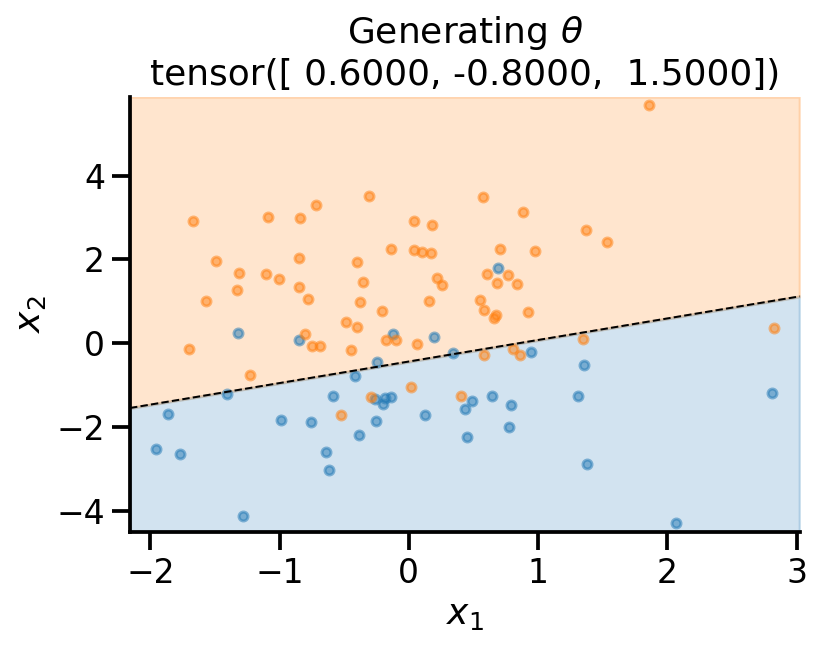

In [92]:
plot_fit(
    x_sample,
    y_sample,
    theta_sample,
    r"Generating $\theta$",
)



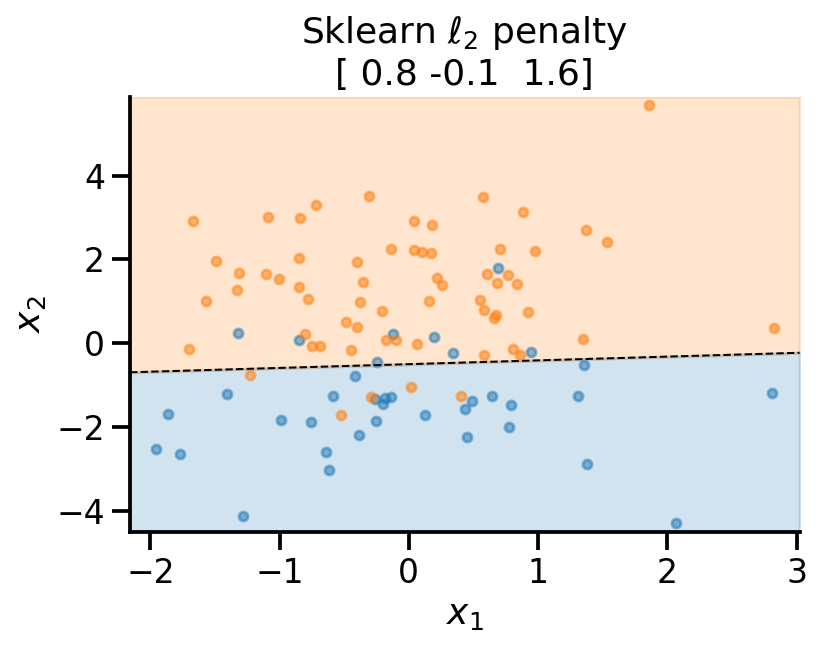

In [88]:
plot_fit(
    x_sample,
    y_sample,
    np.concatenate((lr_l2.intercept_.reshape(-1, 1), lr_l2.coef_), axis=1).flatten(),
    r"Sklearn $\ell_2$ penalty ",
)


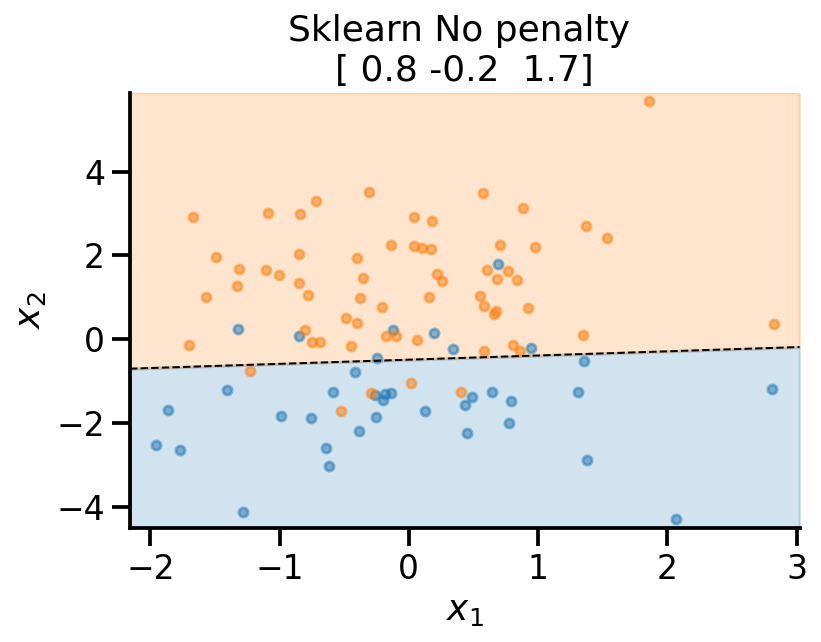

In [89]:
plot_fit(
    x_sample,
    y_sample,
    np.concatenate((lr_none.intercept_.reshape(-1, 1), lr_none.coef_), axis=1).flatten(),
    r"Sklearn No penalty ",
)

### MLE estimate PyTorch

In [96]:
def neg_log_likelihood(theta, x, y):
    x_dash = torch.concat((torch.ones(x.shape[0], 1), x), axis=1)
    p = torch.sigmoid(x_dash@theta)
    y_dist = dist.Bernoulli(probs=p)

    return -torch.sum(y_dist.log_prob(y))

In [97]:
neg_log_likelihood(theta_sample, x_sample, y_sample)

tensor(33.1907)

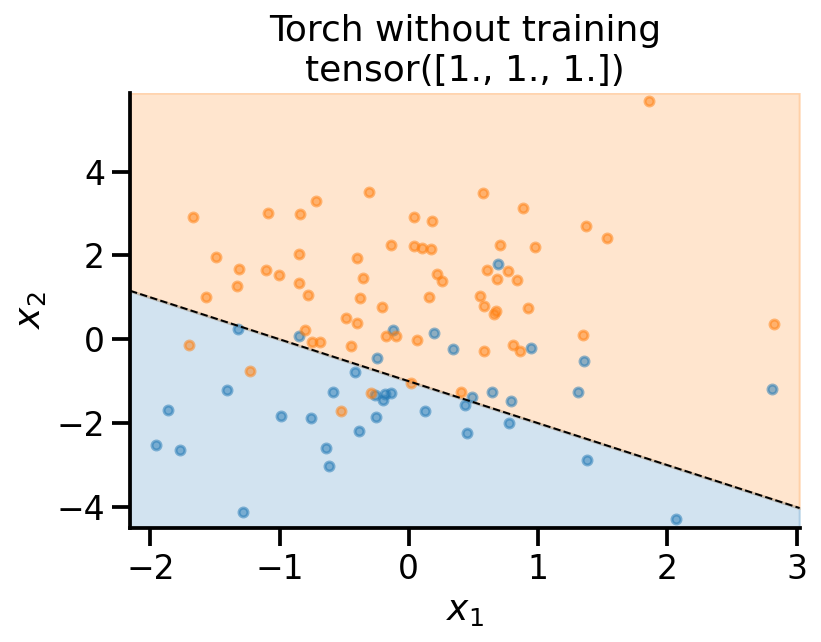

In [114]:
theta_learn_loc = torch.tensor([1., 1., 1.], requires_grad=True)
neg_log_likelihood(theta_learn_loc, x_sample, y_sample)

plot_fit(
    x_sample,
    y_sample,
    theta_learn_loc.detach(),
    r"Torch without training",
)

In [115]:
theta_learn_loc = torch.tensor([0., 0., 0.], requires_grad=True)
loss_array = []
loc_array = []

opt = torch.optim.Adam([theta_learn_loc], lr=0.05)
for i in range(101):
    loss_val = neg_log_likelihood(theta_learn_loc, x_sample, y_sample)
    loss_val.backward()
    loc_array.append(theta_learn_loc)
    loss_array.append(loss_val.item())

    if i % 10 == 0:
        print(
            f"Iteration: {i}, Loss: {loss_val.item():0.2f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 69.31
Iteration: 10, Loss: 44.14
Iteration: 20, Loss: 35.79
Iteration: 30, Loss: 32.73
Iteration: 40, Loss: 31.67
Iteration: 50, Loss: 31.25
Iteration: 60, Loss: 31.08
Iteration: 70, Loss: 31.00
Iteration: 80, Loss: 30.97
Iteration: 90, Loss: 30.95
Iteration: 100, Loss: 30.94


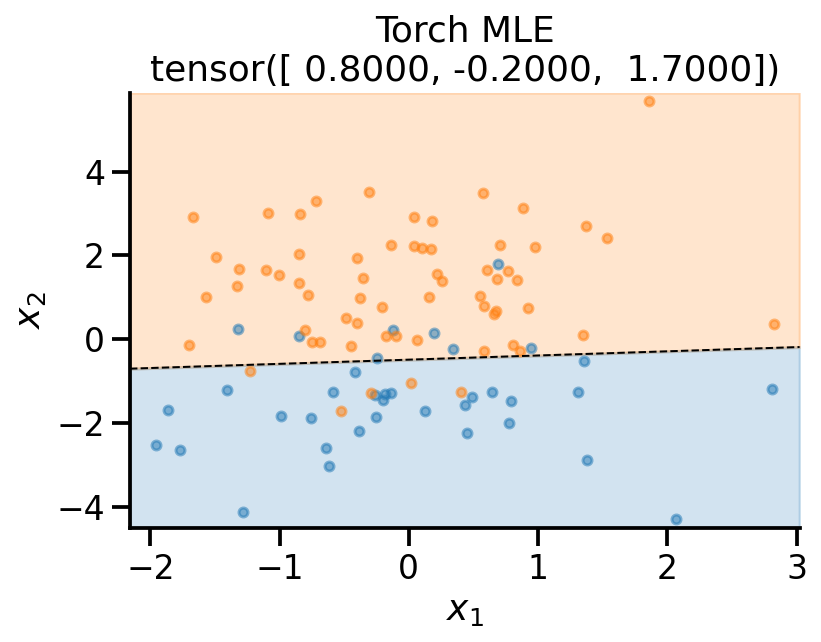

In [116]:
plot_fit(
    x_sample,
    y_sample,
    theta_learn_loc.detach(),
    r"Torch MLE",
)

### MAP estimate PyTorch

In [125]:
prior_theta = dist.MultivariateNormal(loc = torch.tensor([0., 0., 0.]), covariance_matrix=2*torch.eye(3))

logprob = lambda theta: -prior_theta.log_prob(theta)

In [126]:
theta_learn_loc = torch.tensor([0., 0., 0.], requires_grad=True)
loss_array = []
loc_array = []

opt = torch.optim.Adam([theta_learn_loc], lr=0.05)
for i in range(101):
    loss_val = neg_log_likelihood(theta_learn_loc, x_sample, y_sample) + logprob(theta_learn_loc)
    loss_val.backward()
    loc_array.append(theta_learn_loc)
    loss_array.append(loss_val.item())

    if i % 10 == 0:
        print(
            f"Iteration: {i}, Loss: {loss_val.item():0.2f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 73.11
Iteration: 10, Loss: 48.06
Iteration: 20, Loss: 39.89
Iteration: 30, Loss: 37.01
Iteration: 40, Loss: 36.10
Iteration: 50, Loss: 35.78
Iteration: 60, Loss: 35.67
Iteration: 70, Loss: 35.64
Iteration: 80, Loss: 35.62
Iteration: 90, Loss: 35.62
Iteration: 100, Loss: 35.62


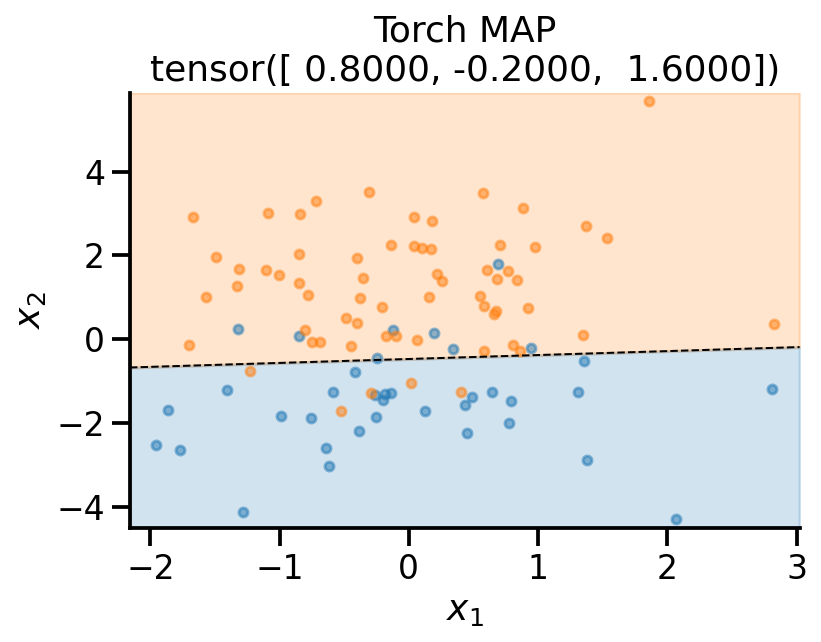

In [127]:
plot_fit(
    x_sample,
    y_sample,
    theta_learn_loc.detach(),
    r"Torch MAP",
)

### References

---

1. Plotting code borrwed from here: https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/